# Get data

In [1]:
import csv
import numpy as np
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split
import sklearn

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D
# from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [11]:
import warnings
print('TensorFlow Version: {}'.format(tf.__version__))
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. You can drastically improve your network training by using a GPU.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [12]:

lines =[]
# with open("../data-car-behavioral/driving_log.csv") as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#     	lines.append(line)

# images = []
# measurements = []
# for line in lines:
# 	source_path = line[0]
# 	filename = source_path.split('/')[-1]
# 	current_path = '../data-car-behavioral/IMG/' + filename
# 	image = cv2.imread(current_path)
# 	images.append(image)
# 	# fleeping images & steering measurements
# 	measurement = float(line[3])
# 	measurements.append(measurement)

# X_train = np.array(images)
# y_train = np.array(measurements)

# images = []
# measurements = []
# for line in lines:
# 	source_path = line[0]
# 	filename = source_path.split('/')[-1]
# 	current_path = '../data-car-behavioral/IMG/' + filename
# 	image = cv2.imread(current_path)
# 	images.append(image)
# 	# fleeping images & steering measurements
# 	measurement = float(line[3])
# 	measurements.append(measurement)

# # data augmentation
# augmented_images, augmented_measurements = [], []
# for image, measurement in zip(images, measurements):
# 	augmented_images.append(image)
# 	augmented_measurements.append(measurement)

# 	augmented_images.append(cv2.flip(image, 1))
# 	augmented_measurements.append(measurement * -1.0)

# X_train = np.array(augmented_images)
# y_train = np.array(augmented_measurements)

car_images = []
steering_angles = []
with open("../data-car-behavioral/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        # lines.append(line)
        steering_center = float(line[3])

        # create adjusted steering measurements for the side camera images
        correction = steering_center * 0.1 # 10%
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        # read in images from center, left and right cameras
        for i in range(3):
            source_path = line[i]
            filename = source_path.split('/')[-1]
            current_path = '../data-car-behavioral/IMG/' + filename
            image = cv2.imread(current_path)
            # add images to data set
            car_images.append(image)

        # add angles to data set	    	
        steering_angles.extend([steering_center, steering_left, steering_right])

## Data augmentation

### Flipping images

In [15]:
# data augmentation by flipping images
augmented_images, augmented_measurements = [], []
for image, measurement in zip(car_images, steering_angles):
    augmented_images.append(image)
    augmented_measurements.append(measurement)

    augmented_images.append(cv2.flip(image, 1))
    augmented_measurements.append(measurement * -1.0)

## Train

In [14]:
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

#### LeNet architecture

In [10]:
def leNet(X_train, y_train):
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    model.add(Conv2D(6, (5, 5), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(6, (5, 5), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5, verbose = 1)

    model.save('model_lenet.h5')
    print("Model saved as model_lenet.h5")
    return history_object.history
    

In [17]:
history = leNet(X_train, y_train)

Train on 13195 samples, validate on 3299 samples
Epoch 1/5
13195/13195 [==============================] - 23s 2ms/step - loss: 0.1395 - val_loss: 0.0977
Epoch 2/5
13195/13195 [==============================] - 23s 2ms/step - loss: 0.0613 - val_loss: 0.0907
Epoch 3/5
13195/13195 [==============================] - 23s 2ms/step - loss: 0.0589 - val_loss: 0.0909
Epoch 4/5
13195/13195 [==============================] - 23s 2ms/step - loss: 0.0564 - val_loss: 0.0900
Epoch 5/5
13195/13195 [==============================] - 23s 2ms/step - loss: 0.0544 - val_loss: 0.0899
Model saved as model_lenet.h5


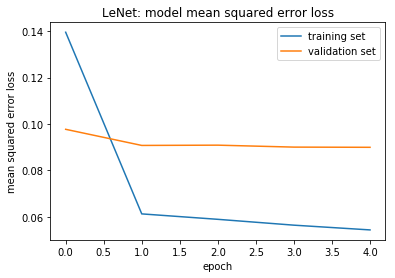

In [19]:
### plot the training and validation loss for each epoch
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('LeNet: model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

**Reflexion**
A high accuracy on the training set but low accuracy on the validation set implies overfitting. So, it seems that our model is overfitting. We can tune that by using different regularization technics like dropout, max-norm, etc. but let's build a more robust architecture.

#### NVidia CNN architecture

In [20]:
img_shape = X_train[0].shape
print(img_shape)

(160, 320, 3)


Not all of these pixels contain useful information, however. In the image above, the top portion of the image captures trees and hills and sky, and the bottom portion of the image captures the hood of the car.

Your model might train faster if you crop each image to focus on only the portion of the image that is useful for predicting a steering angle.

In [21]:
def Nvidia_CNN(X_train, y_train, input_shape=(160, 320, 3)):
    model = Sequential()
    # Preprocess incoming data, centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x/127.5 - 1.,
             input_shape=input_shape))
    # crop images 
#     model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    
    # adding 5 convolutions 
    model.add(Conv2D(24, (5, 5), strides=(2, 2), padding='valid', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), padding='valid', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), padding='valid', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', kernel_initializer='he_normal', activation='relu'))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(1164, kernel_initializer='he_normal'))
    model.add(Dense(100, kernel_initializer='he_normal'))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(Dense(10, kernel_initializer='he_normal'))
    model.add(Dense(1, kernel_initializer='he_normal'))

    model.compile(loss='mse', optimizer='adam')
    history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)

    model.save('model_nvidia.h5')
    print("Model saved as model_nvidia.h5")
    return history_object.history

In [22]:
history = Nvidia_CNN(X_train, y_train, input_shape=img_shape)

Train on 13195 samples, validate on 3299 samples
Epoch 1/5
13195/13195 [==============================] - 82s 6ms/step - loss: 12.9182 - val_loss: 0.1060
Epoch 2/5
13195/13195 [==============================] - 81s 6ms/step - loss: 0.0645 - val_loss: 0.0970
Epoch 3/5
13195/13195 [==============================] - 81s 6ms/step - loss: 0.0624 - val_loss: 0.0952
Epoch 4/5
13195/13195 [==============================] - 81s 6ms/step - loss: 0.0600 - val_loss: 0.0865
Epoch 5/5
13195/13195 [==============================] - 81s 6ms/step - loss: 0.0595 - val_loss: 0.0871
Model saved as model_nvidia.h5


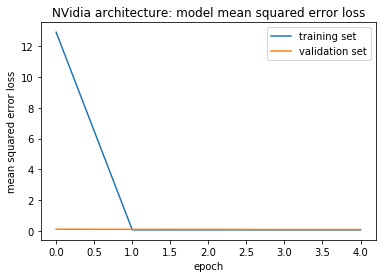

In [24]:
### plot the training and validation loss for each epoch
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('NVidia architecture: model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

**Reflexion**
Even without regularization technics the accuracy seems great enough without observing overfitting.

# More powerful Network 

In [2]:
samples = []
with open("../data-car-behavioral/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [40]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def display_images(images, cmap=None):
    cols = 5
    rows = (len(images) + 1) // cols
    plt.subplots(figsize = (13, 15))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        image = images[i]
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        if i % 5 == 0:
            plt.title('Base Image')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=-40, w_pad=0)
    plt.show()

## Data augmentation

### Brigthness augmentation
Brithness augmentation help us to simulate the day and night conditions.

In [4]:
def brightness_change(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

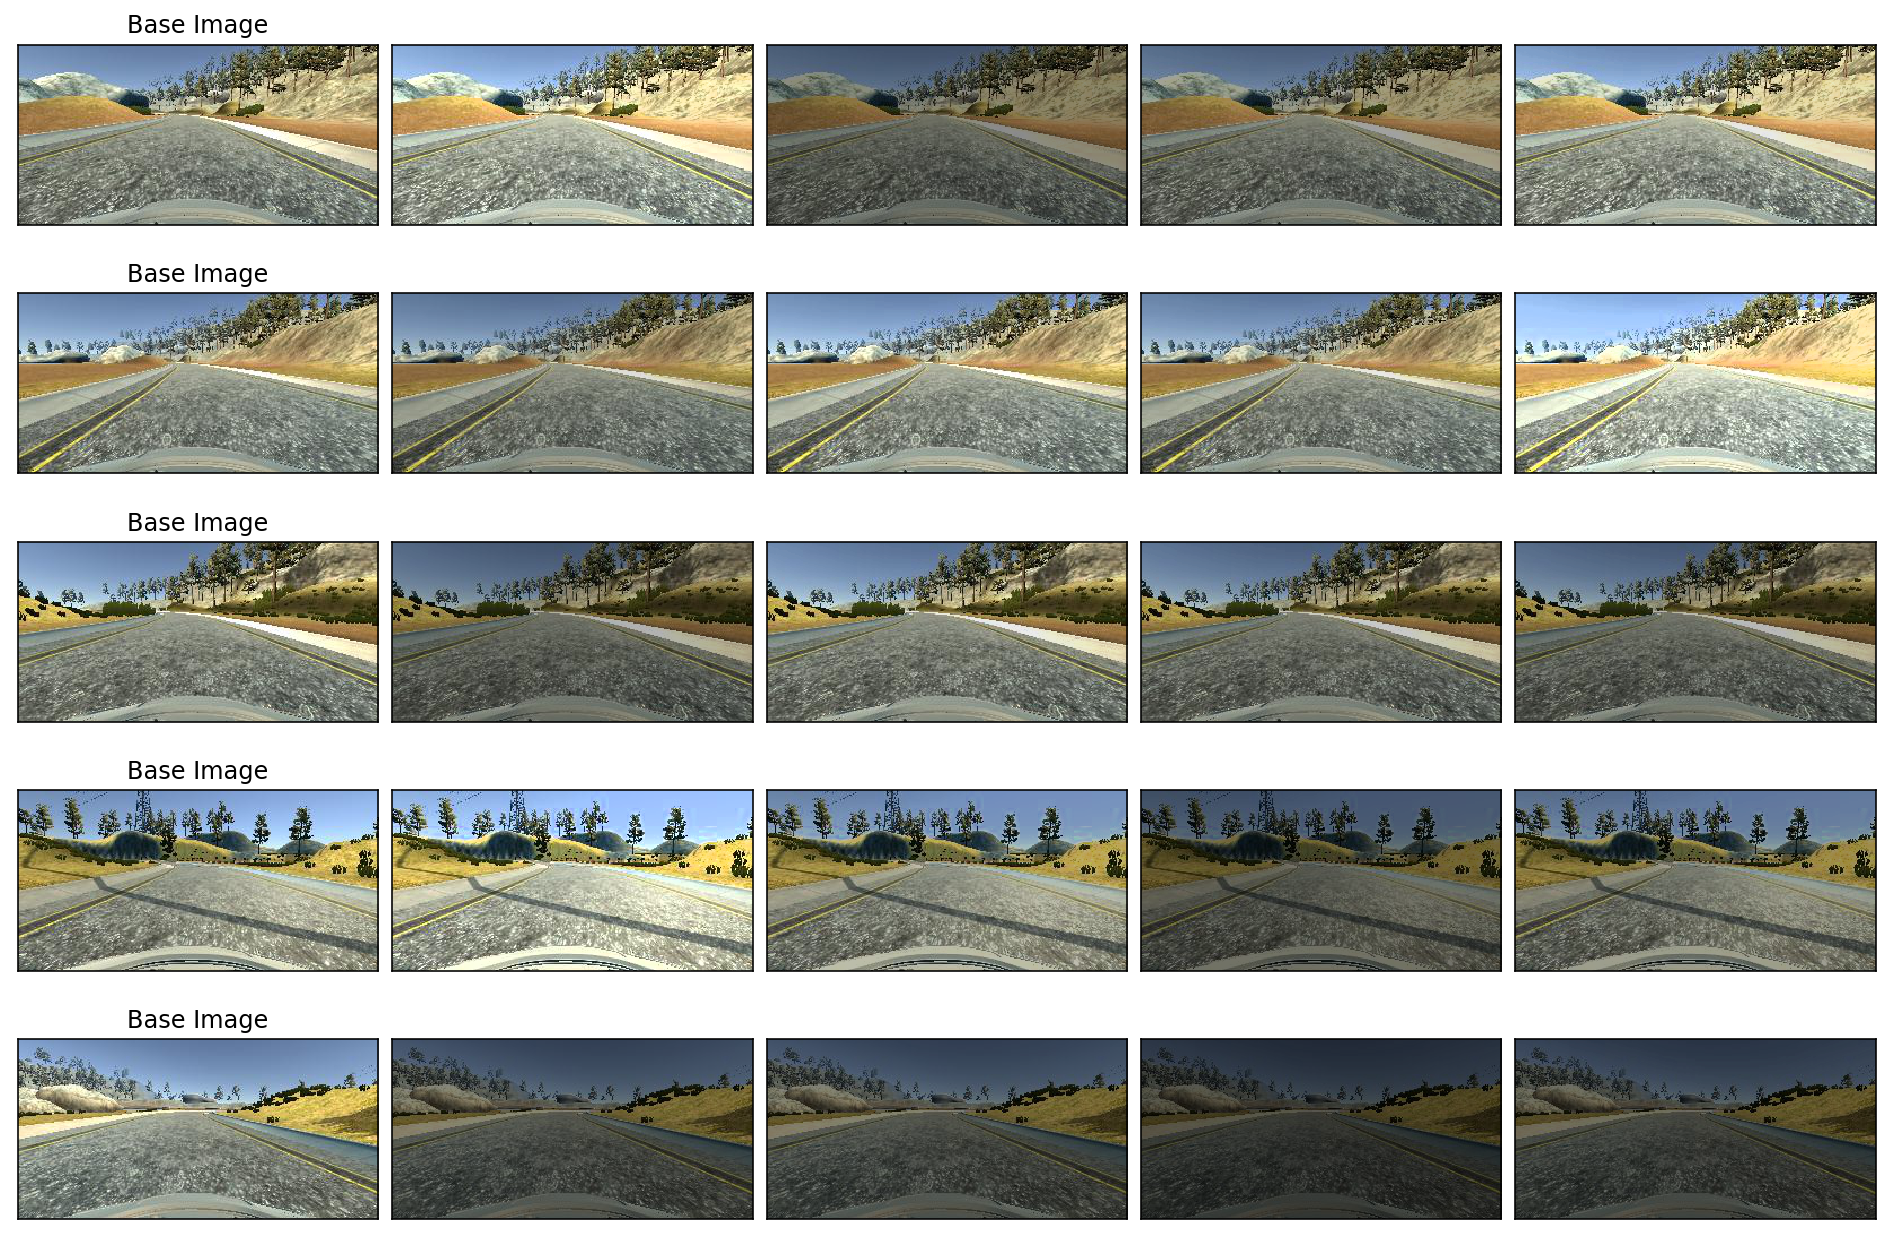

In [41]:
images = []
for _ in range(5):
    index = np.random.randint(0, len(train_samples))              
    batch_sample = train_samples[index]
    source_path = batch_sample[0]
    filename = source_path.split('/')[-1]
    current_path = '../data-car-behavioral/IMG/' + filename
    image = cv2.imread(current_path) 
    # Color image loaded by OpenCV is in BGR mode. But Matplotlib displays in RGB mode.
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    images.append(image)
    for _ in range(4):
        image = brightness_change(image)
        images.append(image)

display_images(images)

#  Generators

Instead of storing the preprocessed data in memory all at once, we will use generators to pull pieces of the data and process them on the fly only when needed, which is much more memory-efficient.

In [4]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: #loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset: offset + batch_size]
            
            car_images = []
            steering_angles = []
            for batch_sample in batch_samples:
                steering_center = float(batch_sample[3])
                
                # create adjusted steering angles for the 2 side camera images (left and right one)
                correction = steering_center * 0.1 #10%
                steering_left = steering_center + correction
                steering_right = steering_center - correction
                
                # read in images from center, left and right cameras
                for i in range(3):
                    source_path = batch_sample[i]
                    filename = source_path.split('/')[-1]
                    current_path = '../data-car-behavioral/IMG/' + filename
                    image = cv2.imread(current_path)                    
                    car_images.append(image)
                    
                steering_angles.extend([steering_center, steering_left, steering_right])
            
            X_train = np.array(car_images)
            y_train = np.array(steering_angles)
            yield sklearn.utils.shuffle(X_train, y_train)

## Training

In [5]:
BATCH_SIZE = 128
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)

row, col, ch = 160, 320, 3

Let's crop images in Keras. This is relatively fast, because the model is parallelized on the GPU, so many images are cropped simultaneously. 

In [8]:
def Nvidia_CNN_gen(train_generator, samples_per_epoch, validation_generator, 
                   num_val_samples, input_shape=(160, 320, 3)):
    model = Sequential()
    # Preprocess incoming data, centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x/127.5 - 1.,
             input_shape=input_shape))
    # crop images 
#     model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    
    # adding 5 convolutions 
    model.add(Conv2D(24, (5, 5), strides=(2, 2), padding='valid', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), padding='valid', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), padding='valid', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', kernel_initializer='he_normal', activation='relu'))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(1164, kernel_initializer='he_normal'))
    model.add(Dense(100, kernel_initializer='he_normal'))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(Dense(10, kernel_initializer='he_normal'))
    model.add(Dense(1, kernel_initializer='he_normal'))

    model.compile(loss='mse', optimizer='adam')
    history_object = model.fit_generator(train_generator, steps_per_epoch=samples_per_epoch,
                        epochs=5,
                        validation_data=validation_generator, validation_steps=num_val_samples,
                                        verbose=1)

    model.save('model_nvidia_gen.h5')
    print("Model saved as model_nvidia_gen.h5")
    return history_object.history

In [9]:
history = Nvidia_CNN_gen(train_generator, len(train_samples), validation_generator, len(validation_samples))

Epoch 1/5
  44/2199 [..............................] - ETA: 52:44 - loss: 285.5726

KeyboardInterrupt: 

## Visualizing loss

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()